# AIA Response Function Tests

In [3]:
import os
import sys
import pickle

import numpy as np
import scipy
import matplotlib.pyplot as plt

import ChiantiPy.core as ch
import sunpy.instr.aia as aia

%matplotlib inline

The goal of this notebook is to test the wavelength and temperature response function calculations that are currently being developed in SunPy. 

## Wavelength Response Functions
First, we'll calculate the wavelength response functions for 6 of the 7 AIA EUV channels: 171, 193, 131, 335, 211, and 94 $\mathrm{\mathring{A}}$.

In [4]:
response = aia.Response(path_to_genx_dir='../ssw_aia_response_data/')

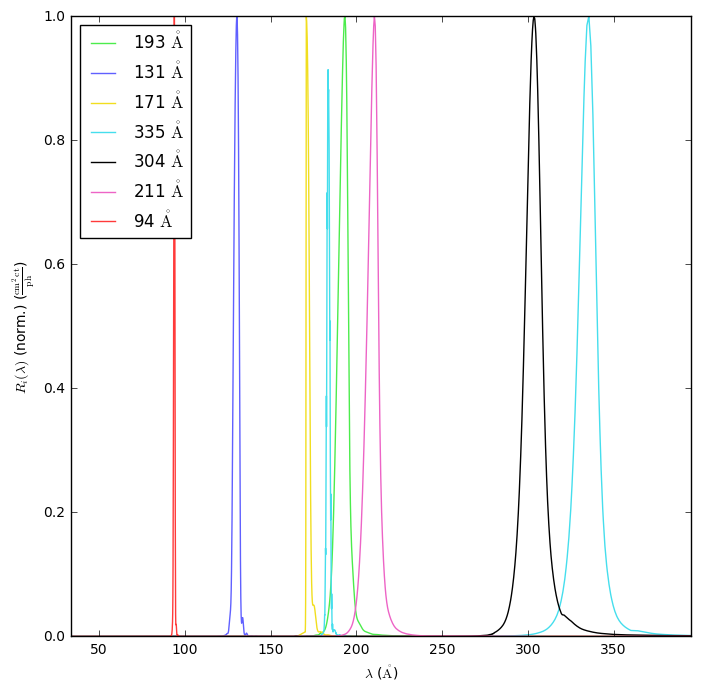

In [5]:
response.calculate_wavelength_response()
response.peek_wavelength_response()

## Contribution Functions, $G(n,T)$

Next, we'll calculate the contribution functions for a couple of ions, hopefully ones that are relatively important to each channel. According to the [AIA LMSAL webpage](http://aia.lmsal.com/public/instrument.htm),

| Channel ($\mathrm{\mathring{A}}$) | Primary Ions | Characteristic Temperature, $\log{T}$ (K) |
|:-------:|:--------------:|:------------------------------:|
| 94  | Fe XVII | 6.8 |
| 131 | Fe VIII, XX, XXIII | 5.6, 7.0, 7.2 |
| 171 | Fe IX | 5.8 |
| 193 | Fe XII, XXIV | 6.1, 7.3 |
| 211 | Fe XIV | 6.3 |
| 335 | Fe XVI | 6.4 |

First, choose a temperature range and constant density.

In [7]:
temperature = np.logspace(5.,8.,50)
density = 1.e+9

Now, make a list of all the ions that we care about so that we can easily iterate through them.

In [8]:
ions = ['fe_8','fe_9','fe_12','fe_14','fe_16','fe_17','fe_20','fe_23','fe_24']
search_interval = np.array([-2.5,2.5])
ion_wvl_ranges = [c+search_interval for c in [131.,171.,193.,211.,335.,94.,131.,131.,193.]]

Finally, iterate through all of the ions and store the contribution function and associated information.

In [10]:
#warning! This takes a long time!
contribution_fns = {}
for i,iwr in zip(ions,ion_wvl_ranges):
    tmp_ion = ch.ion(i,temperature=temperature,eDensity=density,em=1.e+27)
    tmp_ion.gofnt(wvlRange=[iwr[0],iwr[1]],top=3,plot=False)
    plt.show()
    contribution_fns[i] = tmp_ion.Gofnt

## Calculating Temperature Response Functions
From Boerner et al. (2012), the temperature response function $K_i(T)$ is given by
$$
K_i(T)=\int_0^{\infty}\mathrm{d}\lambda\,G(\lambda,T)R_i(\lambda)
$$
First, we need to reshape the contribution functions for our discrete number of ions into $G(\lambda,T)$ such that each column of $G$ is $G_{\lambda}(T)$. Then we can interpolate each $R_i$ over that discrete number of wavelengths.

In [11]:
sorted_g = sorted([g[1] for g in contribution_fns.items()],key=lambda x: x['wvl'])
g_matrix = np.vstack((g['gofnt'] for g in sorted_g)).T
discrete_wavelengths = np.array([g['wvl'] for g in sorted_g])

In [123]:
for key in wavelength_response_fns:
    wavelength_response_fns[key]['wavelength_interpolated'] = discrete_wavelengths[:,0]
    wavelength_response_fns[key]['response_interpolated'] = np.interp(discrete_wavelengths,
                                                                      wavelength_response_fns[key]['wavelength'],
                                                                      wavelength_response_fns[key]['response'])[:,0]

In [124]:
temperature_response = {}
for key in wavelength_response_fns:
    g_times_r = g_matrix*wavelength_response_fns[key]['response_interpolated']
    temperature_response[key] = np.trapz(g_times_r,
                                         wavelength_response_fns[key]['wavelength_interpolated'])

Finally, try to plot all of the temperature response functions.

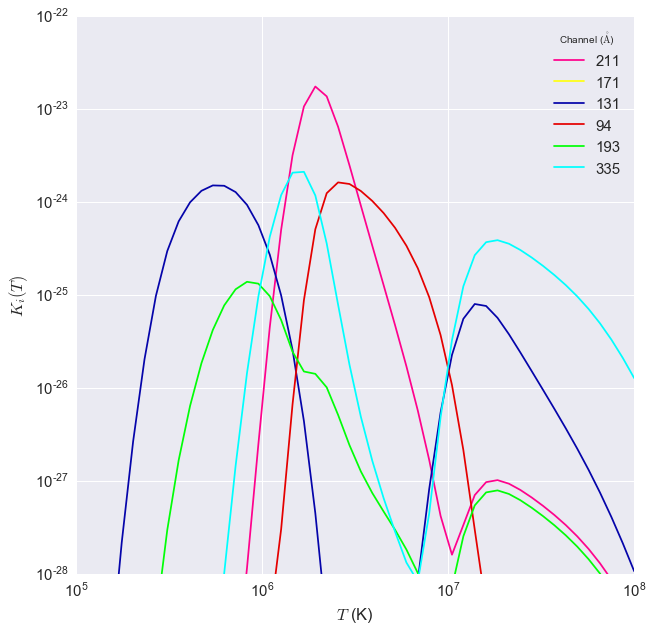

In [125]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for tresp in temperature_response.items():
    ax.plot(temperature,tresp[1],label=str(tresp[0]),color=sns.xkcd_rgb[channel_colors[tresp[0]]])
ax.set_ylim([1e-28,1e-22])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$K_i(T)$')
ax.legend(loc='best',title=r'Channel ($\mathrm{\mathring{A}}$)')

Compare this to the top panel of Fig. 11 in Boerner et al. (2012)